## Project Overview

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import torch
import cv2
import csv
import time
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from tqdm.notebook import tqdm
import torchvision.transforms.functional as TF


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
class config:
    batchsize = 8
    num_epochs = 50
    learning_rate = 1e-4
    num_classes = 4

In [6]:
pd.set_option('future.no_silent_downcasting', True)

## Data Loading, Labels, and Splits

In [7]:
dataset_path  = "./drive/MyDrive/umich_courses/1_fall_2025/1_term_project/data/BACH/ICIAR2018_BACH_Challenge/Photos"
csv_path      = "./drive/MyDrive/umich_courses/1_fall_2025/1_term_project/data/BACH/ICIAR2018_BACH_Challenge/Photos/microscopy_ground_truth.csv"

In [8]:
df = pd.read_csv(csv_path)
image_paths, labels = [], []

for class_name in ["Benign", "InSitu", "Invasive", "Normal"]:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        if img_name.endswith(".tif"):
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(class_name)


image_df = pd.DataFrame({"image_path": image_paths, "label": labels})

image_df["label"] = image_df["label"].replace({"Normal": 0, "Benign": 1, "InSitu": 2, "Invasive": 3}).astype("int64")
image_df = image_df.sample(frac=1, random_state=42).reset_index(drop=True)
image_df.to_csv("bach_training_data.csv", index=False)

dataset = pd.read_csv("bach_training_data.csv")
dataset.head()

,image_path,label
0,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,3
1,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,3
2,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,1
3,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,3
4,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,1


## Preprocessing, Augmentation, and DataLoaders

This section defines image preprocessing steps such as resizing, normalization, and optional augmentation. The processed data is wrapped into PyTorch `Dataset` and `DataLoader` objects so that images can be efficiently batched, shuffled, and fed into the model during training and evaluation.


In [9]:
class BACHDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        label = torch.tensor(self.data.iloc[idx]["label"], dtype=torch.long)
        image = Image.open(img_path).convert("RGB")
        image = cv2.resize(np.array(image), (224, 224), interpolation=cv2.INTER_AREA)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, label

class MinMaxScalerTransform:
    def __call__(self, img):
        img_array = np.array(img).astype(np.float32) / 255.0
        return torch.tensor(img_array).permute(2, 0, 1)

data_transforms = transforms.Compose([
    MinMaxScalerTransform(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

In [10]:
train, temp = train_test_split(dataset, test_size=0.2, stratify=dataset["label"], random_state=42)
val, test = train_test_split(temp, test_size=0.25, stratify=temp["label"], random_state=42)

train_dataset = BACHDataset(train, transform=data_transforms)
val_dataset = BACHDataset(val, transform=None)
test_dataset = BACHDataset(test, transform=None)

train_dataloader = DataLoader(train_dataset, batch_size=config.batchsize, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config.batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config.batchsize, shuffle=True)


Train Samples - Total Batches: 40 | Total Samples: 320


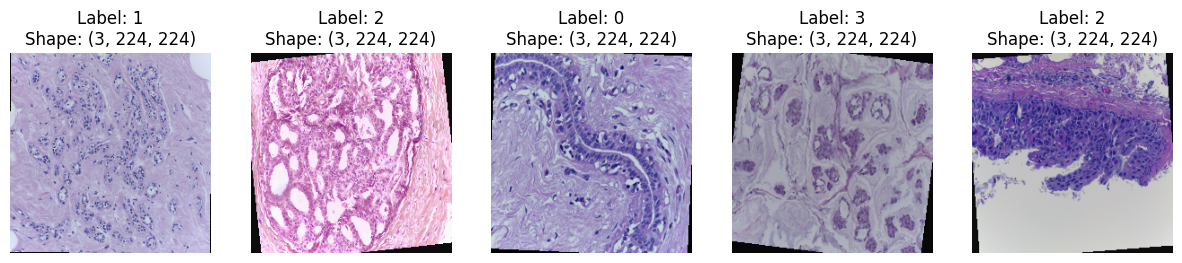


Validation Samples - Total Batches: 8 | Total Samples: 60


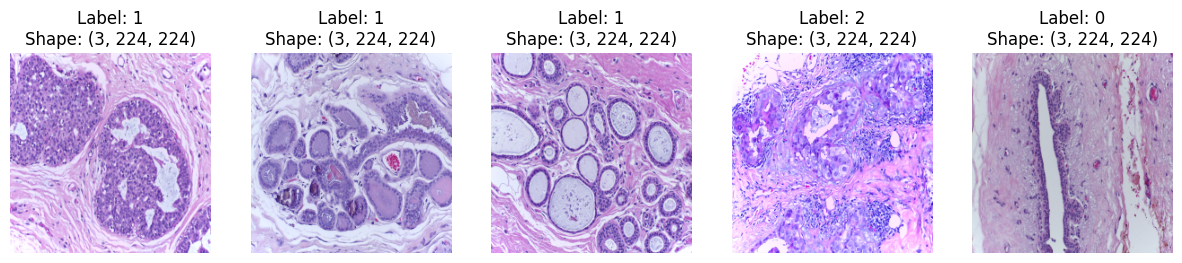


Test Samples - Total Batches: 3 | Total Samples: 20


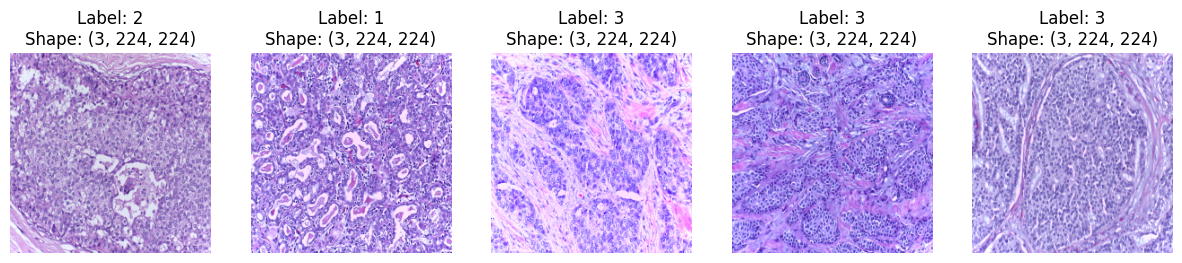

In [11]:
def show_samples(dataloader, title, num_samples=5):
    print(f"\n{title} - Total Batches: {len(dataloader)} | Total Samples: {len(dataloader.dataset)}")


    batch = next(iter(dataloader))

    if isinstance(batch, tuple) and len(batch) == 2:
        images, labels = batch
    elif isinstance(batch, list) and len(batch) == 2:
        images, labels = batch[0], batch[1]
    else:
        raise ValueError(f"Unexpected batch format from DataLoader: {type(batch)}, content: {batch}")


    if isinstance(images, list):
        images = torch.stack(images)


    if images.ndim == 3:
        images = images.unsqueeze(0)

    num_samples = min(num_samples, images.shape[0])


    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]
    for i in range(num_samples):
        img_tensor = images[i]
        img = TF.to_pil_image(img_tensor.cpu())
        label = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
        img_shape = tuple(img_tensor.shape)

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}\nShape: {img_shape}")
        axes[i].axis("off")



    plt.show()

show_samples(train_dataloader, "Train Samples")
show_samples(val_dataloader, "Validation Samples")
show_samples(test_dataloader, "Test Samples")

## Model Architecture & Training Configuration

Here we define the neural network architecture based on a ResNet backbone with a custom classification head adapted to the four BACH classes. We also specify the loss function, optimizer, learning rate, and other hyperparameters that control how the model learns from the data.


In [12]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)


for param in model.layer1.parameters() :
        param.requires_grad = False
for param in model.layer2.parameters() :
        param.requires_grad = False
for param in model.layer3.parameters() :
        param.requires_grad = False
for param in model.layer4.parameters() :
        param.requires_grad = True
num_features = model.fc.in_features
num_classes = 4


model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes)
)


model = model.to(device)


criterion = nn.CrossEntropyLoss()


class_weights = torch.tensor([1.0, 1.5, 1.0, 1.0], dtype=torch.float32).to(device)


criterion_w = nn.CrossEntropyLoss(weight=class_weights)


optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=1e-4)


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


In [13]:
import torch
import torch.nn.functional as F

def convert_to_one_hot(label, num_classes):


    return F.one_hot(torch.tensor(label), num_classes).float()  # Shape: (num_classes,)

def compute_multiclass_metrics(preds_list, labels_list, num_classes):

    # Initialize per-class metric accumulators
    TP_per_class = torch.zeros(num_classes)
    TN_per_class = torch.zeros(num_classes)
    FP_per_class = torch.zeros(num_classes)
    FN_per_class = torch.zeros(num_classes)

    correct = 0
    total = len(labels_list)

    for preds, label in zip(preds_list, labels_list):

        label_one_hot = convert_to_one_hot(label, num_classes)


        pred_class = torch.argmax(preds)
        pred_one_hot = convert_to_one_hot(preds, num_classes)


        if preds == label:
            correct += 1


        for class_idx in range(num_classes):

            TP_per_class[class_idx] += int((pred_one_hot[class_idx] == 1) and (label_one_hot[class_idx] == 1))

            TN_per_class[class_idx] += int((pred_one_hot[class_idx] == 0) and (label_one_hot[class_idx] == 0))

            FP_per_class[class_idx] += int((pred_one_hot[class_idx] == 1) and (label_one_hot[class_idx] == 0))

            FN_per_class[class_idx] += int((pred_one_hot[class_idx] == 0) and (label_one_hot[class_idx] == 1))


    precision_per_class = TP_per_class / (TP_per_class + FP_per_class).clamp(min=1e-10)

    recall_per_class = TP_per_class / (TP_per_class + FN_per_class).clamp(min=1e-10)

    specificity_per_class = TN_per_class / (TN_per_class + FP_per_class).clamp(min=1e-10)

    f1_score_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class).clamp(min=1e-10)



    macro_precision = precision_per_class.mean().item()
    macro_recall = recall_per_class.mean().item()
    macro_specificity = specificity_per_class.mean().item()
    macro_f1_score = f1_score_per_class.mean().item()


    accuracy = correct / total

    return {
        "accuracy": accuracy,
        "precision_per_class": precision_per_class.tolist(),
        "macro_precision": macro_precision,
        "recall_per_class": recall_per_class.tolist(),
        "macro_recall": macro_recall,
        "specificity_per_class": specificity_per_class.tolist(),
        "macro_specificity": macro_specificity,
        "f1_score_per_class": f1_score_per_class.tolist(),
        "macro_f1_score": macro_f1_score
    }

In [14]:
def plot_loss(train_losses, val_losses, num_epochs):
    """Plots training and validation loss curves."""
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o', linestyle='-')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s', linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


## Model Training & Validation

This section implements the training and validation loops. Across multiple epochs, the model is updated using the training set while performance on the validation set is monitored using metrics such as loss, accuracy, and F1-score to detect underfitting or overfitting.


In [15]:
def train_model(model, optimizer, criterion, train_dataloader, val_dataloader, num_epochs, device, num_classes, model_path, csv_name):

    log_fields = ["epoch", "time", "train_loss", "val_loss", "train_precision", "val_precision",
              "train_recall", "val_recall", "train_F1_Score", "val_F1_Score"]
    total_training_time = 0
    best_val_F1_Score = 0

    train_losses = []
    val_losses = []

    with open(csv_name, 'w', newline='', encoding='utf-8') as csvfile:
         writer = csv.DictWriter(csvfile, fieldnames=log_fields)
         writer.writeheader()

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()

        total_loss = 0
        correct = 0
        total = 0

        all_preds = []
        all_labels = []



        train_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")

        for images, labels in train_iterator:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = F.softmax(outputs, dim=1)
            preds = torch.argmax(preds, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)


            all_preds.append(preds.detach().cpu())
            all_labels.append(labels.detach().cpu())

            train_iterator.set_postfix(loss=f"{loss:.4f}")

        epoch_time = time.time() - start_time
        total_training_time += epoch_time
        accuracy = correct / total


        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)


        metrics = compute_multiclass_metrics(all_preds, all_labels, num_classes)

        epoch_train_loss = total_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)


        # Print metrics for each class
        print(f"Epoch {epoch + 1} - Loss: {epoch_train_loss:.4f}, Accuracy: {accuracy:.4f}, Time: {epoch_time:.2f}s")
        print(f"Macro Precision: {metrics['macro_precision']:.4f}, Macro Recall: {metrics['macro_recall']:.4f}, Macro F1-score: {metrics['macro_f1_score']:.4f}")

        for class_idx in range(num_classes):
            print(f"Class {class_idx} - Precision: {metrics['precision_per_class'][class_idx]:.4f}, Recall: {metrics['recall_per_class'][class_idx]:.4f}, F1-score: {metrics['f1_score_per_class'][class_idx]:.4f}")

        all_val_preds,all_val_labels,val_accuracy, val_loss = valid_model(model,criterion, val_dataloader, device, epoch, num_classes)
        val_metrics = compute_multiclass_metrics(all_val_preds, all_val_labels, num_classes)
        val_losses.append(val_loss)
        print("Validation_Metrics")
        print(f"Epoch {epoch + 1} - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
        print(f"Macro Precision: {val_metrics['macro_precision']:.4f}, Macro Recall: {val_metrics['macro_recall']:.4f}, Macro F1-score: {val_metrics['macro_f1_score']:.4f}")

        for class_idx in range(num_classes):
            print(f"Class {class_idx} - Precision: {val_metrics['precision_per_class'][class_idx]:.4f}, Recall: {val_metrics['recall_per_class'][class_idx]:.4f}, F1-score: {val_metrics['f1_score_per_class'][class_idx]:.4f}")

            # Save best model based on Dice score
        if val_metrics['macro_f1_score'] > best_val_F1_Score:
            best_val_F1_Score = val_metrics['macro_f1_score']
            torch.save(model.state_dict(), model_path)
            print(f"Model saved at epoch {epoch+1} with F1_score: {best_val_F1_Score:.4f}")
            # Log training and validation metrics
        with open(csv_name, 'a', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=log_fields)
            writer.writerow({
                "epoch": epoch + 1,
                "time": round(epoch_time, 2),
                "train_loss": round(total_loss/len(train_dataloader), 4),
                "val_loss": round(val_loss, 4),
                "train_precision": round(metrics['macro_precision'], 4),
                "val_precision": round(val_metrics['macro_precision'], 4),
                "train_recall": round(metrics['macro_recall'], 4),
                "val_recall": round(val_metrics['macro_recall'], 4),
                "train_F1_Score": round(metrics['macro_f1_score'], 4),
                "val_F1_Score": round(val_metrics['macro_f1_score'], 4),

            })


    print(f"Training Complete in {total_training_time:.4f}s with {total_training_time/num_epochs:.4f}s per epoch with Best_F1_Score {best_val_F1_Score:.4f}.")
    print(f"Best Validation F1 Score: {best_val_F1_Score:.4f}")

    plot_loss(train_losses, val_losses, num_epochs)

In [16]:
def valid_model(model,criterion, dataloader, device, epoch, num_classes):

    all_val_preds = []
    all_val_labels = []
    val_loss = 0
    val_correct = 0
    val_total= 0
    model.eval()

    val_iterator = tqdm(dataloader, desc=f"Epoch {epoch + 1}")

    with torch.no_grad():
            for images,labels  in val_iterator:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = F.softmax(outputs, dim=1)
                preds = torch.argmax(preds, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)


                all_val_preds.append(preds.detach().cpu())
                all_val_labels.append(labels.detach().cpu())

    val_iterator.set_postfix(loss=f"{loss:.4f}")
    val_accuracy = val_correct / val_total
    all_val_preds = torch.cat(all_val_preds, dim=0)
    all_val_labels = torch.cat(all_val_labels, dim=0)
    val_loss /= len(dataloader)
    scheduler.step(val_loss)

    return all_val_preds,all_val_labels,val_accuracy, val_loss


In [17]:
def inference_model(model, model_path, dataloader, device, num_classes):


    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()

    all_preds = []
    all_labels = []

    inference_iterator = tqdm(dataloader, desc="Running Inference")

    start_time = time.time()

    with torch.no_grad():
        for images, labels in inference_iterator:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            preds = F.softmax(outputs, dim=1)
            preds = torch.argmax(preds, dim=1)


            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())


    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)


    metrics = compute_multiclass_metrics(all_preds, all_labels, num_classes)

    # confusion matrix heatmap
    # Convert tensors to numpy arrays
    y_true = all_labels.numpy()
    y_pred = all_preds.numpy()

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Class names must match your label encoding:
    # "Normal": 0, "Benign": 1, "InSitu": 2, "Invasive": 3
    class_names = ["Normal", "Benign", "InSitu", "Invasive"]

    # Plot confusion matrix
    plot_confusion_matrix(
        cm,
        class_names=class_names,
        title="Confusion Matrix - Test Set",

        save_path="confusion_matrix_test.png"  # or None if you don't want to save
    )


    inference_time = time.time() - start_time
    print(f"\nInference Completed in {inference_time:.2f}s")

    print(f"\nMacro Precision: {metrics['macro_precision']:.4f}, Macro Recall: {metrics['macro_recall']:.4f}, Macro F1-score: {metrics['macro_f1_score']:.4f}")

    for class_idx in range(num_classes):
        print(f"Class {class_idx} - Precision: {metrics['precision_per_class'][class_idx]:.4f}, Recall: {metrics['recall_per_class'][class_idx]:.4f}, F1-score: {metrics['f1_score_per_class'][class_idx]:.4f}")




In [18]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", save_path=None):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="gray_r",
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.5,
        linecolor=None#'black'
    )
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Confusion matrix saved to: {save_path}")

    plt.show()


Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 - Loss: 1.3802, Accuracy: 0.2906, Time: 223.36s
Macro Precision: 0.1613, Macro Recall: 0.2906, Macro F1-score: 0.1897
Class 0 - Precision: 0.3803, Recall: 0.3375, F1-score: 0.3576
Class 1 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Class 2 - Precision: 0.2651, Recall: 0.8250, F1-score: 0.4012
Class 3 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/tmp/ipython-input-324665692.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return F.one_hot(torch.tensor(label), num_classes).float()  # Shape: (num_classes,)


Epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 1 - Loss: 1.3533, Accuracy: 0.3500
Macro Precision: 0.1833, Macro Recall: 0.3500, Macro F1-score: 0.2250
Class 0 - Precision: 0.3333, Recall: 1.0000, F1-score: 0.5000
Class 1 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Class 2 - Precision: 0.4000, Recall: 0.4000, F1-score: 0.4000
Class 3 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Model saved at epoch 1 with F1_score: 0.2250


Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2 - Loss: 1.2970, Accuracy: 0.3344, Time: 21.40s
Macro Precision: 0.4299, Macro Recall: 0.3344, Macro F1-score: 0.2457
Class 0 - Precision: 0.3440, Recall: 0.9375, F1-score: 0.5034
Class 1 - Precision: 0.3333, Recall: 0.0250, F1-score: 0.0465
Class 2 - Precision: 0.2644, Recall: 0.2875, F1-score: 0.2754
Class 3 - Precision: 0.7778, Recall: 0.0875, F1-score: 0.1573


Epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 2 - Loss: 1.2189, Accuracy: 0.6667
Macro Precision: 0.7841, Macro Recall: 0.6667, Macro F1-score: 0.6005
Class 0 - Precision: 0.5357, Recall: 1.0000, F1-score: 0.6977
Class 1 - Precision: 1.0000, Recall: 0.0667, F1-score: 0.1250
Class 2 - Precision: 0.6842, Recall: 0.8667, F1-score: 0.7647
Class 3 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148
Model saved at epoch 2 with F1_score: 0.6005


Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3 - Loss: 1.1103, Accuracy: 0.6000, Time: 21.33s
Macro Precision: 0.5923, Macro Recall: 0.6000, Macro F1-score: 0.5884
Class 0 - Precision: 0.5818, Recall: 0.8000, F1-score: 0.6737
Class 1 - Precision: 0.4333, Recall: 0.3250, F1-score: 0.3714
Class 2 - Precision: 0.6515, Recall: 0.5375, F1-score: 0.5890
Class 3 - Precision: 0.7024, Recall: 0.7375, F1-score: 0.7195


Epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 3 - Loss: 0.8416, Accuracy: 0.7333
Macro Precision: 0.7449, Macro Recall: 0.7333, Macro F1-score: 0.7193
Class 0 - Precision: 0.6667, Recall: 0.9333, F1-score: 0.7778
Class 1 - Precision: 0.7500, Recall: 0.4000, F1-score: 0.5217
Class 2 - Precision: 0.7059, Recall: 0.8000, F1-score: 0.7500
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Model saved at epoch 3 with F1_score: 0.7193


Epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4 - Loss: 0.8269, Accuracy: 0.6906, Time: 21.32s
Macro Precision: 0.6824, Macro Recall: 0.6906, Macro F1-score: 0.6826
Class 0 - Precision: 0.7558, Recall: 0.8125, F1-score: 0.7831
Class 1 - Precision: 0.5932, Recall: 0.4375, F1-score: 0.5036
Class 2 - Precision: 0.6279, Recall: 0.6750, F1-score: 0.6506
Class 3 - Precision: 0.7528, Recall: 0.8375, F1-score: 0.7929


Epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 4 - Loss: 0.7301, Accuracy: 0.7167
Macro Precision: 0.7072, Macro Recall: 0.7167, Macro F1-score: 0.7074
Class 0 - Precision: 0.7500, Recall: 0.8000, F1-score: 0.7742
Class 1 - Precision: 0.5455, Recall: 0.4000, F1-score: 0.4615
Class 2 - Precision: 0.6667, Recall: 0.8000, F1-score: 0.7273
Class 3 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667


Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5 - Loss: 0.6310, Accuracy: 0.7531, Time: 20.86s
Macro Precision: 0.7503, Macro Recall: 0.7531, Macro F1-score: 0.7501
Class 0 - Precision: 0.8243, Recall: 0.7625, F1-score: 0.7922
Class 1 - Precision: 0.6338, Recall: 0.5625, F1-score: 0.5960
Class 2 - Precision: 0.7500, Recall: 0.8250, F1-score: 0.7857
Class 3 - Precision: 0.7931, Recall: 0.8625, F1-score: 0.8263


Epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 5 - Loss: 0.6530, Accuracy: 0.7667
Macro Precision: 0.7726, Macro Recall: 0.7667, Macro F1-score: 0.7555
Class 0 - Precision: 0.7000, Recall: 0.9333, F1-score: 0.8000
Class 1 - Precision: 0.7778, Recall: 0.4667, F1-score: 0.5833
Class 2 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000
Class 3 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Model saved at epoch 5 with F1_score: 0.7555


Epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6 - Loss: 0.4923, Accuracy: 0.8125, Time: 21.29s
Macro Precision: 0.8096, Macro Recall: 0.8125, Macro F1-score: 0.8094
Class 0 - Precision: 0.8684, Recall: 0.8250, F1-score: 0.8462
Class 1 - Precision: 0.7143, Recall: 0.6250, F1-score: 0.6667
Class 2 - Precision: 0.8068, Recall: 0.8875, F1-score: 0.8452
Class 3 - Precision: 0.8488, Recall: 0.9125, F1-score: 0.8795


Epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 6 - Loss: 0.8698, Accuracy: 0.7667
Macro Precision: 0.7707, Macro Recall: 0.7667, Macro F1-score: 0.7589
Class 0 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235
Class 1 - Precision: 0.8000, Recall: 0.5333, F1-score: 0.6400
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Model saved at epoch 6 with F1_score: 0.7589


Epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7 - Loss: 0.3517, Accuracy: 0.8750, Time: 21.32s
Macro Precision: 0.8759, Macro Recall: 0.8750, Macro F1-score: 0.8751
Class 0 - Precision: 0.9067, Recall: 0.8500, F1-score: 0.8774
Class 1 - Precision: 0.8072, Recall: 0.8375, F1-score: 0.8221
Class 2 - Precision: 0.8750, Recall: 0.8750, F1-score: 0.8750
Class 3 - Precision: 0.9146, Recall: 0.9375, F1-score: 0.9259


Epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 7 - Loss: 0.9930, Accuracy: 0.7167
Macro Precision: 0.7202, Macro Recall: 0.7167, Macro F1-score: 0.6955
Class 0 - Precision: 0.7000, Recall: 0.9333, F1-score: 0.8000
Class 1 - Precision: 0.7143, Recall: 0.3333, F1-score: 0.4545
Class 2 - Precision: 0.6667, Recall: 0.8000, F1-score: 0.7273
Class 3 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000


Epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8 - Loss: 0.3590, Accuracy: 0.8719, Time: 21.11s
Macro Precision: 0.8737, Macro Recall: 0.8719, Macro F1-score: 0.8726
Class 0 - Precision: 0.8750, Recall: 0.8750, F1-score: 0.8750
Class 1 - Precision: 0.7738, Recall: 0.8125, F1-score: 0.7927
Class 2 - Precision: 0.9091, Recall: 0.8750, F1-score: 0.8917
Class 3 - Precision: 0.9367, Recall: 0.9250, F1-score: 0.9308


Epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 8 - Loss: 0.7492, Accuracy: 0.7500
Macro Precision: 0.7459, Macro Recall: 0.7500, Macro F1-score: 0.7452
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.6154, Recall: 0.5333, F1-score: 0.5714
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 9:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9 - Loss: 0.3303, Accuracy: 0.8875, Time: 20.97s
Macro Precision: 0.8868, Macro Recall: 0.8875, Macro F1-score: 0.8869
Class 0 - Precision: 0.9012, Recall: 0.9125, F1-score: 0.9068
Class 1 - Precision: 0.8052, Recall: 0.7750, F1-score: 0.7898
Class 2 - Precision: 0.9359, Recall: 0.9125, F1-score: 0.9241
Class 3 - Precision: 0.9048, Recall: 0.9500, F1-score: 0.9268


Epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 9 - Loss: 0.9800, Accuracy: 0.7167
Macro Precision: 0.7369, Macro Recall: 0.7167, Macro F1-score: 0.7122
Class 0 - Precision: 0.6087, Recall: 0.9333, F1-score: 0.7368
Class 1 - Precision: 0.6364, Recall: 0.4667, F1-score: 0.5385
Class 2 - Precision: 0.7857, Recall: 0.7333, F1-score: 0.7586
Class 3 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148


Epoch 10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10 - Loss: 0.1997, Accuracy: 0.9406, Time: 21.26s
Macro Precision: 0.9404, Macro Recall: 0.9406, Macro F1-score: 0.9405
Class 0 - Precision: 0.9241, Recall: 0.9125, F1-score: 0.9182
Class 1 - Precision: 0.9000, Recall: 0.9000, F1-score: 0.9000
Class 2 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 3 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877


Epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 10 - Loss: 0.8933, Accuracy: 0.7500
Macro Precision: 0.7600, Macro Recall: 0.7500, Macro F1-score: 0.7445
Class 0 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235
Class 1 - Precision: 0.6364, Recall: 0.4667, F1-score: 0.5385
Class 2 - Precision: 0.6667, Recall: 0.8000, F1-score: 0.7273
Class 3 - Precision: 1.0000, Recall: 0.8000, F1-score: 0.8889


Epoch 11:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11 - Loss: 0.1778, Accuracy: 0.9313, Time: 21.17s
Macro Precision: 0.9309, Macro Recall: 0.9313, Macro F1-score: 0.9306
Class 0 - Precision: 0.9474, Recall: 0.9000, F1-score: 0.9231
Class 1 - Precision: 0.8961, Recall: 0.8625, F1-score: 0.8790
Class 2 - Precision: 0.9398, Recall: 0.9750, F1-score: 0.9571
Class 3 - Precision: 0.9405, Recall: 0.9875, F1-score: 0.9634


Epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 11 - Loss: 0.9399, Accuracy: 0.7500
Macro Precision: 0.7583, Macro Recall: 0.7500, Macro F1-score: 0.7454
Class 0 - Precision: 0.7000, Recall: 0.9333, F1-score: 0.8000
Class 1 - Precision: 0.6667, Recall: 0.5333, F1-score: 0.5926
Class 2 - Precision: 0.7500, Recall: 0.8000, F1-score: 0.7742
Class 3 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148


Epoch 12:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12 - Loss: 0.1619, Accuracy: 0.9500, Time: 21.34s
Macro Precision: 0.9503, Macro Recall: 0.9500, Macro F1-score: 0.9500
Class 0 - Precision: 0.9277, Recall: 0.9625, F1-score: 0.9448
Class 1 - Precision: 0.9114, Recall: 0.9000, F1-score: 0.9057
Class 2 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686
Class 3 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811


Epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 12 - Loss: 0.8374, Accuracy: 0.8000
Macro Precision: 0.7999, Macro Recall: 0.8000, Macro F1-score: 0.7986
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7143, Recall: 0.6667, F1-score: 0.6897
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Model saved at epoch 12 with F1_score: 0.7986


Epoch 13:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13 - Loss: 0.1550, Accuracy: 0.9406, Time: 21.52s
Macro Precision: 0.9411, Macro Recall: 0.9406, Macro F1-score: 0.9407
Class 0 - Precision: 0.9610, Recall: 0.9250, F1-score: 0.9427
Class 1 - Precision: 0.9136, Recall: 0.9250, F1-score: 0.9193
Class 2 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 3 - Precision: 0.9277, Recall: 0.9625, F1-score: 0.9448


Epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 13 - Loss: 0.8605, Accuracy: 0.7833
Macro Precision: 0.7930, Macro Recall: 0.7833, Macro F1-score: 0.7841
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.6250, Recall: 0.6667, F1-score: 0.6452
Class 2 - Precision: 0.8462, Recall: 0.7333, F1-score: 0.7857
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 14:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14 - Loss: 0.1394, Accuracy: 0.9563, Time: 21.08s
Macro Precision: 0.9563, Macro Recall: 0.9562, Macro F1-score: 0.9561
Class 0 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 1 - Precision: 0.9481, Recall: 0.9125, F1-score: 0.9299
Class 2 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 3 - Precision: 0.9398, Recall: 0.9750, F1-score: 0.9571


Epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 14 - Loss: 0.9891, Accuracy: 0.7667
Macro Precision: 0.7611, Macro Recall: 0.7667, Macro F1-score: 0.7603
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.6667, Recall: 0.5333, F1-score: 0.5926
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667


Epoch 15:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15 - Loss: 0.1006, Accuracy: 0.9625, Time: 21.14s
Macro Precision: 0.9628, Macro Recall: 0.9625, Macro F1-score: 0.9624
Class 0 - Precision: 0.9390, Recall: 0.9625, F1-score: 0.9506
Class 1 - Precision: 0.9737, Recall: 0.9250, F1-score: 0.9487
Class 2 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753
Class 3 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750


Epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 15 - Loss: 0.9024, Accuracy: 0.7500
Macro Precision: 0.7459, Macro Recall: 0.7500, Macro F1-score: 0.7452
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.6154, Recall: 0.5333, F1-score: 0.5714
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 16:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16 - Loss: 0.1142, Accuracy: 0.9656, Time: 21.29s
Macro Precision: 0.9654, Macro Recall: 0.9656, Macro F1-score: 0.9654
Class 0 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 1 - Precision: 0.9481, Recall: 0.9125, F1-score: 0.9299
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753


Epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 16 - Loss: 0.9361, Accuracy: 0.7833
Macro Precision: 0.7807, Macro Recall: 0.7833, Macro F1-score: 0.7799
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6923, Recall: 0.6000, F1-score: 0.6429
Class 2 - Precision: 0.7500, Recall: 0.8000, F1-score: 0.7742
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 17:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17 - Loss: 0.1190, Accuracy: 0.9688, Time: 21.30s
Macro Precision: 0.9688, Macro Recall: 0.9688, Macro F1-score: 0.9687
Class 0 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 1 - Precision: 0.9487, Recall: 0.9250, F1-score: 0.9367
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 0.9518, Recall: 0.9875, F1-score: 0.9693


Epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 17 - Loss: 0.9218, Accuracy: 0.7667
Macro Precision: 0.7642, Macro Recall: 0.7667, Macro F1-score: 0.7642
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6429, Recall: 0.6000, F1-score: 0.6207
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 18:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18 - Loss: 0.0963, Accuracy: 0.9781, Time: 20.91s
Macro Precision: 0.9781, Macro Recall: 0.9781, Macro F1-score: 0.9781
Class 0 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 1 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811


Epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 18 - Loss: 0.9092, Accuracy: 0.7667
Macro Precision: 0.7642, Macro Recall: 0.7667, Macro F1-score: 0.7642
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6429, Recall: 0.6000, F1-score: 0.6207
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 19:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19 - Loss: 0.0951, Accuracy: 0.9688, Time: 21.31s
Macro Precision: 0.9688, Macro Recall: 0.9688, Macro F1-score: 0.9687
Class 0 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 1 - Precision: 0.9375, Recall: 0.9375, F1-score: 0.9375
Class 2 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 3 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814


Epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 19 - Loss: 1.0848, Accuracy: 0.7667
Macro Precision: 0.7654, Macro Recall: 0.7667, Macro F1-score: 0.7647
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7143, Recall: 0.6667, F1-score: 0.6897
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20 - Loss: 0.0965, Accuracy: 0.9656, Time: 21.01s
Macro Precision: 0.9661, Macro Recall: 0.9656, Macro F1-score: 0.9655
Class 0 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686
Class 1 - Precision: 0.9610, Recall: 0.9250, F1-score: 0.9427
Class 2 - Precision: 0.9412, Recall: 1.0000, F1-score: 0.9697
Class 3 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811


Epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 20 - Loss: 1.0474, Accuracy: 0.7667
Macro Precision: 0.7649, Macro Recall: 0.7667, Macro F1-score: 0.7640
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7692, Recall: 0.6667, F1-score: 0.7143
Class 3 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000


Epoch 21:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21 - Loss: 0.1011, Accuracy: 0.9625, Time: 21.21s
Macro Precision: 0.9629, Macro Recall: 0.9625, Macro F1-score: 0.9626
Class 0 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620
Class 1 - Precision: 0.9268, Recall: 0.9500, F1-score: 0.9383
Class 2 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 3 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753


Epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 21 - Loss: 0.8796, Accuracy: 0.8000
Macro Precision: 0.8050, Macro Recall: 0.8000, Macro F1-score: 0.8001
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6875, Recall: 0.7333, F1-score: 0.7097
Class 2 - Precision: 0.7857, Recall: 0.7333, F1-score: 0.7586
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571
Model saved at epoch 21 with F1_score: 0.8001


Epoch 22:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22 - Loss: 0.0807, Accuracy: 0.9812, Time: 21.27s
Macro Precision: 0.9814, Macro Recall: 0.9812, Macro F1-score: 0.9812
Class 0 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 1 - Precision: 0.9630, Recall: 0.9750, F1-score: 0.9689
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877


Epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 22 - Loss: 0.9394, Accuracy: 0.7500
Macro Precision: 0.7452, Macro Recall: 0.7500, Macro F1-score: 0.7463
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6429, Recall: 0.6000, F1-score: 0.6207
Class 2 - Precision: 0.7143, Recall: 0.6667, F1-score: 0.6897
Class 3 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000


Epoch 23:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23 - Loss: 0.1044, Accuracy: 0.9625, Time: 21.30s
Macro Precision: 0.9623, Macro Recall: 0.9625, Macro F1-score: 0.9623
Class 0 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620
Class 1 - Precision: 0.9359, Recall: 0.9125, F1-score: 0.9241
Class 2 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 3 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753


Epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 23 - Loss: 1.0793, Accuracy: 0.7833
Macro Precision: 0.7818, Macro Recall: 0.7833, Macro F1-score: 0.7797
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.6923, Recall: 0.6000, F1-score: 0.6429
Class 2 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 24:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24 - Loss: 0.0692, Accuracy: 0.9844, Time: 21.11s
Macro Precision: 0.9845, Macro Recall: 0.9844, Macro F1-score: 0.9844
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9630, Recall: 0.9750, F1-score: 0.9689
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875


Epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 24 - Loss: 0.9075, Accuracy: 0.7833
Macro Precision: 0.7867, Macro Recall: 0.7833, Macro F1-score: 0.7830
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 25:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25 - Loss: 0.0532, Accuracy: 0.9906, Time: 21.33s
Macro Precision: 0.9906, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 1 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 25 - Loss: 0.8741, Accuracy: 0.7833
Macro Precision: 0.7867, Macro Recall: 0.7833, Macro F1-score: 0.7830
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 26:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26 - Loss: 0.0943, Accuracy: 0.9719, Time: 21.40s
Macro Precision: 0.9720, Macro Recall: 0.9719, Macro F1-score: 0.9719
Class 0 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 1 - Precision: 0.9383, Recall: 0.9500, F1-score: 0.9441
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686


Epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 26 - Loss: 0.9079, Accuracy: 0.7833
Macro Precision: 0.7833, Macro Recall: 0.7833, Macro F1-score: 0.7820
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7857, Recall: 0.7333, F1-score: 0.7586
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 27:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27 - Loss: 0.0500, Accuracy: 0.9875, Time: 21.33s
Macro Precision: 0.9877, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 3 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875


Epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 27 - Loss: 0.8440, Accuracy: 0.7667
Macro Precision: 0.7642, Macro Recall: 0.7667, Macro F1-score: 0.7642
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6429, Recall: 0.6000, F1-score: 0.6207
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 28:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28 - Loss: 0.0558, Accuracy: 0.9844, Time: 21.42s
Macro Precision: 0.9846, Macro Recall: 0.9844, Macro F1-score: 0.9844
Class 0 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 1 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 28 - Loss: 0.9352, Accuracy: 0.7833
Macro Precision: 0.7790, Macro Recall: 0.7833, Macro F1-score: 0.7795
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6923, Recall: 0.6000, F1-score: 0.6429
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667


Epoch 29:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29 - Loss: 0.0587, Accuracy: 0.9875, Time: 21.29s
Macro Precision: 0.9879, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 2 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 3 - Precision: 0.9639, Recall: 1.0000, F1-score: 0.9816


Epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 29 - Loss: 0.9262, Accuracy: 0.7667
Macro Precision: 0.7642, Macro Recall: 0.7667, Macro F1-score: 0.7642
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6429, Recall: 0.6000, F1-score: 0.6207
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 30:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30 - Loss: 0.0740, Accuracy: 0.9844, Time: 21.46s
Macro Precision: 0.9846, Macro Recall: 0.9844, Macro F1-score: 0.9844
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9639, Recall: 1.0000, F1-score: 0.9816


Epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 30 - Loss: 1.0375, Accuracy: 0.7667
Macro Precision: 0.7642, Macro Recall: 0.7667, Macro F1-score: 0.7642
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6429, Recall: 0.6000, F1-score: 0.6207
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 31:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31 - Loss: 0.0737, Accuracy: 0.9812, Time: 21.47s
Macro Precision: 0.9813, Macro Recall: 0.9812, Macro F1-score: 0.9813
Class 0 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 1 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814


Epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 31 - Loss: 1.0019, Accuracy: 0.7833
Macro Precision: 0.7807, Macro Recall: 0.7833, Macro F1-score: 0.7799
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6923, Recall: 0.6000, F1-score: 0.6429
Class 2 - Precision: 0.7500, Recall: 0.8000, F1-score: 0.7742
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 32:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32 - Loss: 0.0623, Accuracy: 0.9750, Time: 21.36s
Macro Precision: 0.9751, Macro Recall: 0.9750, Macro F1-score: 0.9749
Class 0 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686
Class 1 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 0.9639, Recall: 1.0000, F1-score: 0.9816


Epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 32 - Loss: 0.9847, Accuracy: 0.7833
Macro Precision: 0.7867, Macro Recall: 0.7833, Macro F1-score: 0.7830
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 33:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33 - Loss: 0.0629, Accuracy: 0.9844, Time: 21.30s
Macro Precision: 0.9846, Macro Recall: 0.9844, Macro F1-score: 0.9844
Class 0 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 1 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 33 - Loss: 0.9214, Accuracy: 0.7667
Macro Precision: 0.7642, Macro Recall: 0.7667, Macro F1-score: 0.7642
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6429, Recall: 0.6000, F1-score: 0.6207
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 34:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34 - Loss: 0.0922, Accuracy: 0.9719, Time: 21.29s
Macro Precision: 0.9728, Macro Recall: 0.9719, Macro F1-score: 0.9719
Class 0 - Precision: 0.9870, Recall: 0.9500, F1-score: 0.9682
Class 1 - Precision: 0.9294, Recall: 0.9875, F1-score: 0.9576
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 0.9870, Recall: 0.9500, F1-score: 0.9682


Epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 34 - Loss: 0.8591, Accuracy: 0.7833
Macro Precision: 0.7833, Macro Recall: 0.7833, Macro F1-score: 0.7820
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7857, Recall: 0.7333, F1-score: 0.7586
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 35:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35 - Loss: 0.0679, Accuracy: 0.9750, Time: 21.42s
Macro Precision: 0.9750, Macro Recall: 0.9750, Macro F1-score: 0.9749
Class 0 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620
Class 1 - Precision: 0.9500, Recall: 0.9500, F1-score: 0.9500
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877


Epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 35 - Loss: 0.9944, Accuracy: 0.7833
Macro Precision: 0.7833, Macro Recall: 0.7833, Macro F1-score: 0.7820
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7857, Recall: 0.7333, F1-score: 0.7586
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 36:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36 - Loss: 0.0807, Accuracy: 0.9719, Time: 21.44s
Macro Precision: 0.9721, Macro Recall: 0.9719, Macro F1-score: 0.9719
Class 0 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 1 - Precision: 0.9506, Recall: 0.9625, F1-score: 0.9565
Class 2 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 3 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873


Epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 36 - Loss: 0.9075, Accuracy: 0.7833
Macro Precision: 0.7867, Macro Recall: 0.7833, Macro F1-score: 0.7830
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 37:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37 - Loss: 0.0596, Accuracy: 0.9781, Time: 21.60s
Macro Precision: 0.9783, Macro Recall: 0.9781, Macro F1-score: 0.9781
Class 0 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 1 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9639, Recall: 1.0000, F1-score: 0.9816


Epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 37 - Loss: 1.2645, Accuracy: 0.7833
Macro Precision: 0.7858, Macro Recall: 0.7833, Macro F1-score: 0.7807
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.6923, Recall: 0.6000, F1-score: 0.6429
Class 2 - Precision: 0.7500, Recall: 0.8000, F1-score: 0.7742
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 38:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38 - Loss: 0.0655, Accuracy: 0.9906, Time: 21.46s
Macro Precision: 0.9906, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 1 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 38 - Loss: 0.9761, Accuracy: 0.7833
Macro Precision: 0.7867, Macro Recall: 0.7833, Macro F1-score: 0.7830
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 39:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39 - Loss: 0.0460, Accuracy: 0.9938, Time: 21.37s
Macro Precision: 0.9938, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 39 - Loss: 0.9975, Accuracy: 0.7833
Macro Precision: 0.7867, Macro Recall: 0.7833, Macro F1-score: 0.7830
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 40:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40 - Loss: 0.0759, Accuracy: 0.9719, Time: 21.36s
Macro Precision: 0.9724, Macro Recall: 0.9719, Macro F1-score: 0.9720
Class 0 - Precision: 1.0000, Recall: 0.9625, F1-score: 0.9809
Class 1 - Precision: 0.9390, Recall: 0.9625, F1-score: 0.9506
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 0.9630, Recall: 0.9750, F1-score: 0.9689


Epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 40 - Loss: 0.9752, Accuracy: 0.8000
Macro Precision: 0.8050, Macro Recall: 0.8000, Macro F1-score: 0.8001
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6875, Recall: 0.7333, F1-score: 0.7097
Class 2 - Precision: 0.7857, Recall: 0.7333, F1-score: 0.7586
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 41:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41 - Loss: 0.0569, Accuracy: 0.9844, Time: 21.41s
Macro Precision: 0.9846, Macro Recall: 0.9844, Macro F1-score: 0.9844
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875


Epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 41 - Loss: 1.2925, Accuracy: 0.7833
Macro Precision: 0.7867, Macro Recall: 0.7833, Macro F1-score: 0.7830
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 42:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42 - Loss: 0.0673, Accuracy: 0.9812, Time: 21.29s
Macro Precision: 0.9818, Macro Recall: 0.9813, Macro F1-score: 0.9813
Class 0 - Precision: 1.0000, Recall: 0.9625, F1-score: 0.9809
Class 1 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753
Class 2 - Precision: 0.9639, Recall: 1.0000, F1-score: 0.9816
Class 3 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873


Epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 42 - Loss: 0.9242, Accuracy: 0.7833
Macro Precision: 0.7867, Macro Recall: 0.7833, Macro F1-score: 0.7830
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 43:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43 - Loss: 0.0648, Accuracy: 0.9875, Time: 21.30s
Macro Precision: 0.9877, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811


Epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 43 - Loss: 0.9853, Accuracy: 0.7833
Macro Precision: 0.7867, Macro Recall: 0.7833, Macro F1-score: 0.7830
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 44:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44 - Loss: 0.0582, Accuracy: 0.9812, Time: 21.33s
Macro Precision: 0.9815, Macro Recall: 0.9812, Macro F1-score: 0.9813
Class 0 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 1 - Precision: 0.9512, Recall: 0.9750, F1-score: 0.9630
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875


Epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 44 - Loss: 1.0997, Accuracy: 0.7667
Macro Precision: 0.7693, Macro Recall: 0.7667, Macro F1-score: 0.7649
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.6429, Recall: 0.6000, F1-score: 0.6207
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 45:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45 - Loss: 0.0603, Accuracy: 0.9812, Time: 21.26s
Macro Precision: 0.9816, Macro Recall: 0.9813, Macro F1-score: 0.9813
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9512, Recall: 0.9750, F1-score: 0.9630
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750


Epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 45 - Loss: 0.9483, Accuracy: 0.7667
Macro Precision: 0.7642, Macro Recall: 0.7667, Macro F1-score: 0.7642
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6429, Recall: 0.6000, F1-score: 0.6207
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 46:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46 - Loss: 0.0461, Accuracy: 0.9906, Time: 21.23s
Macro Precision: 0.9908, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 46 - Loss: 1.0006, Accuracy: 0.7667
Macro Precision: 0.7642, Macro Recall: 0.7667, Macro F1-score: 0.7642
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6429, Recall: 0.6000, F1-score: 0.6207
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 47:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47 - Loss: 0.0686, Accuracy: 0.9688, Time: 21.49s
Macro Precision: 0.9693, Macro Recall: 0.9688, Macro F1-score: 0.9689
Class 0 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 1 - Precision: 0.9277, Recall: 0.9625, F1-score: 0.9448
Class 2 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 3 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747


Epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 47 - Loss: 1.2866, Accuracy: 0.7667
Macro Precision: 0.7629, Macro Recall: 0.7667, Macro F1-score: 0.7607
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.6667, Recall: 0.5333, F1-score: 0.5926
Class 2 - Precision: 0.7500, Recall: 0.8000, F1-score: 0.7742
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 48:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48 - Loss: 0.0516, Accuracy: 0.9844, Time: 21.40s
Macro Precision: 0.9846, Macro Recall: 0.9844, Macro F1-score: 0.9844
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753
Class 2 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 48 - Loss: 0.9644, Accuracy: 0.7833
Macro Precision: 0.7833, Macro Recall: 0.7833, Macro F1-score: 0.7820
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7857, Recall: 0.7333, F1-score: 0.7586
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 49:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49 - Loss: 0.0637, Accuracy: 0.9781, Time: 21.62s
Macro Precision: 0.9781, Macro Recall: 0.9781, Macro F1-score: 0.9781
Class 0 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 1 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814


Epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 49 - Loss: 1.0475, Accuracy: 0.7833
Macro Precision: 0.7790, Macro Recall: 0.7833, Macro F1-score: 0.7795
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6923, Recall: 0.6000, F1-score: 0.6429
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667


Epoch 50:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50 - Loss: 0.0746, Accuracy: 0.9812, Time: 21.33s
Macro Precision: 0.9813, Macro Recall: 0.9812, Macro F1-score: 0.9812
Class 0 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 1 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814


Epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 50 - Loss: 1.0805, Accuracy: 0.7833
Macro Precision: 0.7867, Macro Recall: 0.7833, Macro F1-score: 0.7830
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571
Training Complete in 1267.1687s with 25.3434s per epoch with Best_F1_Score 0.8001.
Best Validation F1 Score: 0.8001


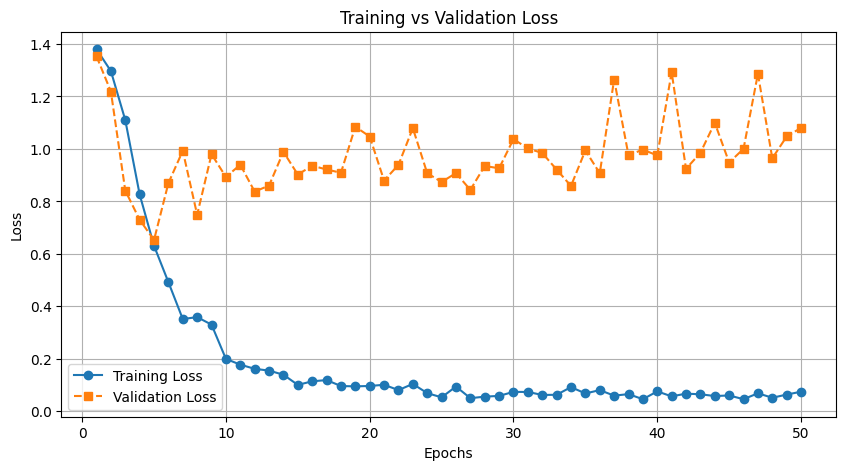

In [19]:
train_model(model, optimizer, criterion, train_dataloader, val_dataloader, config.num_epochs, device,config.num_classes, model_path="best_model1.pth", csv_name="training_results1.csv")

## Test Evaluation & Result Visualization

Here we evaluate the trained model on the held-out test set to estimate real-world performance. Metrics and visualizations such as confusion matrices and sample predictions are used to understand how well the model distinguishes between the different breast cancer subtypes.


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipython-input-324665692.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return F.one_hot(torch.tensor(label), num_classes).float()  # Shape: (num_classes,)


Confusion matrix saved to: confusion_matrix_test.png


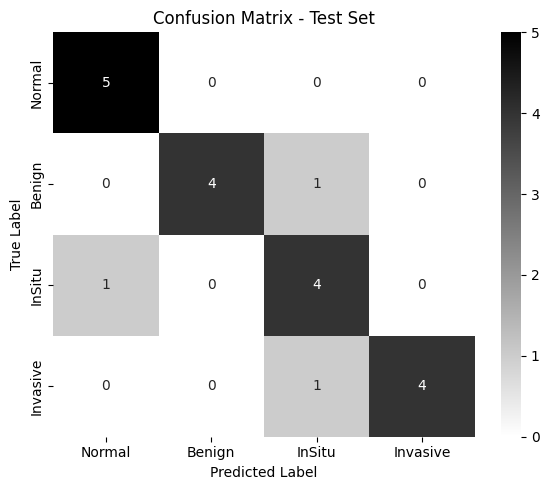


Inference Completed in 8.25s

Macro Precision: 0.8750, Macro Recall: 0.8500, Macro F1-score: 0.8535
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 1.0000, Recall: 0.8000, F1-score: 0.8889
Class 2 - Precision: 0.6667, Recall: 0.8000, F1-score: 0.7273
Class 3 - Precision: 1.0000, Recall: 0.8000, F1-score: 0.8889


In [20]:
best_model_path = "./drive/MyDrive/umich_courses/1_fall_2025/1_term_project/code/best_model1.pth"
inference_model(model, best_model_path, test_dataloader, device, config.num_classes)